In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import sklearn
import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# make a simple dataset with numerical columns and categorical columns

raw_data = pd.DataFrame(
    {
        "age": [25, 30, 35, 20, 25, 30, 35, 40, 45, 50],
        "income": [
            50000,
            70000,
            90000,
            30000,
            40000,
            60000,
            80000,
            100000,
            150000,
            200000,
        ],
        "sex": ["M", "F", "F", "M", "Na", "Na", "M", "F", "Na", "F"],
        "bought": ["N", "N", "Y", "N", "Y", "Y", "Y", "N", "Y", "Y"],
        "test": ["A", "B", "C", "A", "B", "C", "A", "B", "C", "A"],
    }
)
raw_data

,age,income,sex,bought,test
0,25,50000,M,N,A
1,30,70000,F,N,B
2,35,90000,F,Y,C
3,20,30000,M,N,A
4,25,40000,Na,Y,B
5,30,60000,Na,Y,C
6,35,80000,M,Y,A
7,40,100000,F,N,B
8,45,150000,Na,Y,C
9,50,200000,F,Y,A


In [4]:
from sklearn.preprocessing import StandardScaler

data = pd.get_dummies(raw_data, columns=["sex"])
scaler = StandardScaler()
data[["age", "income"]] = scaler.fit_transform(data[["age", "income"]])
data

,age,income,bought,test,sex_F,sex_M,sex_Na
0,-0.948847,-0.742828,N,A,False,True,False
1,-0.390702,-0.341299,N,B,True,False,False
2,0.167444,0.060229,Y,C,True,False,False
3,-1.506993,-1.144357,N,A,False,True,False
4,-0.948847,-0.943592,Y,B,False,False,True
5,-0.390702,-0.542064,Y,C,False,False,True
6,0.167444,-0.140535,Y,A,False,True,False
7,0.725589,0.260994,N,B,True,False,False
8,1.283735,1.264815,Y,C,False,False,True
9,1.841880,2.268637,Y,A,True,False,False


In [5]:
# create single result category combine 'bought' and 'test'
data["result"] = data["bought"] + data["test"]
data = data.drop(columns=["bought", "test"])
data

,age,income,sex_F,sex_M,sex_Na,result
0,-0.948847,-0.742828,False,True,False,NA
1,-0.390702,-0.341299,True,False,False,NB
2,0.167444,0.060229,True,False,False,YC
3,-1.506993,-1.144357,False,True,False,NA
4,-0.948847,-0.943592,False,False,True,YB
5,-0.390702,-0.542064,False,False,True,YC
6,0.167444,-0.140535,False,True,False,YA
7,0.725589,0.260994,True,False,False,NB
8,1.283735,1.264815,False,False,True,YC
9,1.841880,2.268637,True,False,False,YA


In [6]:
class_names = data["result"].unique()
num_classes = len(class_names)
data["result"] = pd.Categorical(data["result"], categories=class_names).codes
label_to_class_name = dict(enumerate(class_names))
class_name_to_label = {v: k for k, v in label_to_class_name.items()}
data.head()

,age,income,sex_F,sex_M,sex_Na,result
0,-0.948847,-0.742828,False,True,False,0
1,-0.390702,-0.341299,True,False,False,1
2,0.167444,0.060229,True,False,False,2
3,-1.506993,-1.144357,False,True,False,0
4,-0.948847,-0.943592,False,False,True,3


In [7]:
class_name_to_label, label_to_class_name

({'NA': 0, 'NB': 1, 'YC': 2, 'YB': 3, 'YA': 4},
 {0: 'NA', 1: 'NB', 2: 'YC', 3: 'YB', 4: 'YA'})

In [8]:
# convert all cols except 'result' to numeric
data[["sex_F", "sex_M", "sex_Na"]] = data[["sex_F", "sex_M", "sex_Na"]].astype(int)
data.head()

,age,income,sex_F,sex_M,sex_Na,result
0,-0.948847,-0.742828,0,1,0,0
1,-0.390702,-0.341299,1,0,0,1
2,0.167444,0.060229,1,0,0,2
3,-1.506993,-1.144357,0,1,0,0
4,-0.948847,-0.943592,0,0,1,3


In [9]:
# triple the number of rows and add some random variation
data = pd.concat([data, data, data])

data["age"] = data["age"] + np.random.randn(data.shape[0]) * 0.1
data["income"] = data["income"] + np.random.randn(data.shape[0]) * 0.1

print(len(data))
data.head()

30


,age,income,sex_F,sex_M,sex_Na,result
0,-0.938479,-0.837216,0,1,0,0
1,-0.270149,-0.381497,1,0,0,1
2,0.134478,-0.006803,1,0,0,2
3,-1.345802,-1.118703,0,1,0,0
4,-0.791500,-1.075766,0,0,1,3


In [10]:
classes = data["result"].unique()


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = dataframe.drop(["result"], axis=1).values
        self.targets = dataframe[["result"]].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.tensor(self.features[index], dtype=torch.float32)
        y = torch.tensor(self.targets[index], dtype=torch.long).squeeze()
        return x, y

In [11]:
split = int(0.8 * len(data))
# shuffle first
data = data.sample(frac=1).reset_index(drop=True)
train_rows = data[:split]
test_rows = data[split:]
len(train_rows), len(test_rows)

(24, 6)

In [12]:
train_data = CustomDataset(train_rows)
test_data = CustomDataset(test_rows)

len(train_data), len(test_data)

(24, 6)

In [13]:
train_data.targets.shape

(24, 1)

In [14]:
train_data.features[:4], train_data.targets[:4]

(array([[ 0.84568286,  0.17826871,  1.        ,  0.        ,  0.        ],
        [-1.63548817, -1.21433431,  0.        ,  1.        ,  0.        ],
        [ 1.07013969,  1.27316991,  0.        ,  0.        ,  1.        ],
        [ 0.2046504 ,  0.16443118,  1.        ,  0.        ,  0.        ]]),
 array([[1],
        [0],
        [2],
        [2]], dtype=int8))

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=2, shuffle=False)

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([2, 5]), torch.Size([2]))

In [16]:
class CustomModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [17]:
model_0 = CustomModel(input_shape=5, hidden_units=10, output_shape=num_classes).to(
    device
)

In [18]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("../runs/model_0")

In [26]:
# make example prediction


model_0.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        y_preds = model_0(X)
        print(X.shape, y_preds.shape, y.shape)
    writer.add_graph(model_0, X)
        
writer.close()

torch.Size([2, 5]) torch.Size([2, 5]) torch.Size([2])
torch.Size([2, 5]) torch.Size([2, 5]) torch.Size([2])
torch.Size([2, 5]) torch.Size([2, 5]) torch.Size([2])


In [20]:
def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
):
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        model.train()
        y_logits = model(X)
        y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        loss = loss_fn(y_logits, y)
        acc = accuracy_fn(y_true=y, y_pred=y_preds)

        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [21]:
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            y_logits = model(X)
            y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            loss = loss_fn(y_logits, y)
            acc = accuracy_fn(y_true=y, y_pred=y_preds)

            test_loss += loss.item()
            test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

In [22]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm


def train_model(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_score: callable,
    epochs: int = 3,
) -> dict[str, list[float]]:

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_score,
        )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_score,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

/root/repos/pytorch-learn/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.1)

model_0_train_results = train_model(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_score=accuracy_score,
    epochs=50,
)

100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


In [24]:
writer = SummaryWriter("../runs/model_0")

for epoch in range(len(model_0_train_results["train_loss"])):
    writer.add_scalars(
        "loss",
        {
            "train_loss": model_0_train_results["train_loss"][epoch],
            "test_loss": model_0_train_results["test_loss"][epoch],
        },
        epoch,
    )
    writer.add_scalars(
        "accuracy",
        {
            "train_acc": model_0_train_results["train_acc"][epoch],
            "test_acc": model_0_train_results["test_acc"][epoch],
        },
        epoch,
    )

writer.close()

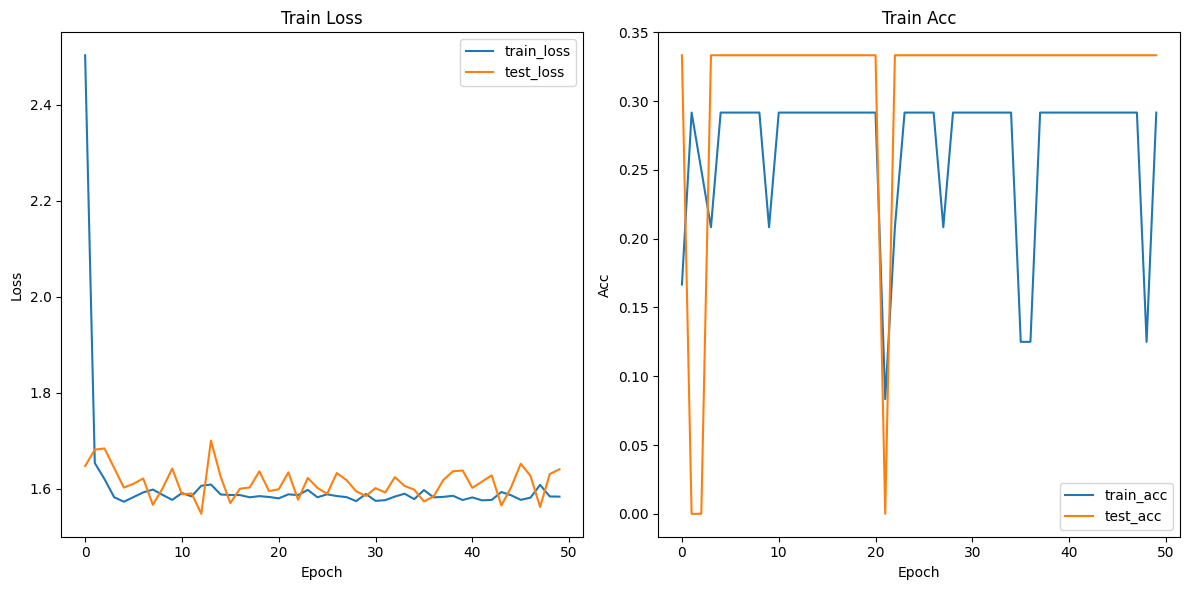

In [25]:
plt.figure(figsize=(12, 6))

# Plotting loss and accuracy
for i, metric in enumerate(["loss", "acc"]):
    plt.subplot(1, 2, i + 1)
    for key in model_0_train_results:
        if metric in key:
            plt.plot(
                range(len(model_0_train_results[key])),
                model_0_train_results[key],
                label=key,
            )
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(f"Train {metric.capitalize()}")
    plt.legend()

plt.tight_layout()
plt.show()